In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys as sys
from astropy.io import ascii
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import matplotlib.colors as colors
import skymapper as skm
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u
import gala.coordinates as gc
import astropy.modeling.projections as proj
import healpy as hp
import matplotlib.patches as patches

In [2]:
parent_path = '/home/polmassana/Documents/PhD/SFH/SMC_test5_field/'
path_outputs = parent_path+'outputs/'
path_solvesfh = parent_path+'sfh_solve/'

In [3]:
catalogue_all = fits.getdata(path_outputs+'SMASH_catalogue_SMC.fits.gz')

In [11]:
skymapper = fits.getdata(path_outputs+'SMASH_info_for_norm_SMC.fits.gz')

In [10]:
catalogue_all.shape[0]/74

281800.2702702703

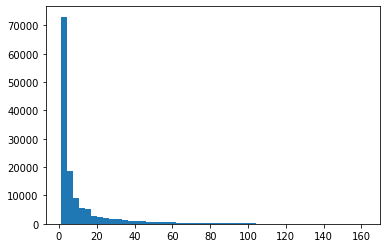

In [13]:
plt.hist(skymapper['counts'], bins=50)
plt.show()

In [4]:
colour = catalogue_all['G'] - catalogue_all['Ag'] + catalogue_all['Ai'] - catalogue_all['I']
mag = catalogue_all['I'] - catalogue_all['Ai']

In [5]:
xbinsize = 0.01
ybinsize = 0.03
xbins = np.arange( start = -1.5, stop = 3+xbinsize, step = xbinsize)
ybins = np.arange( start = 14, stop = 25+ybinsize, step = ybinsize)

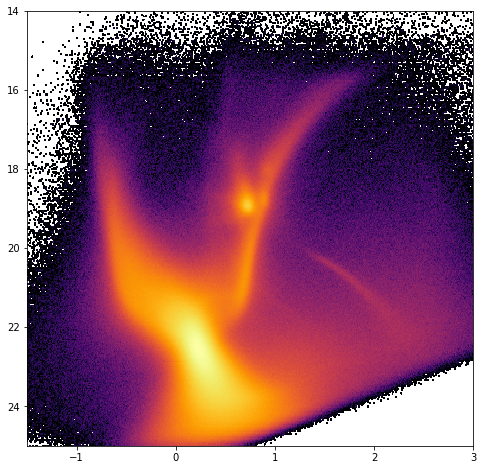

In [14]:
plt.figure(figsize=(8,8))
plt.hist2d(colour, mag, bins=[xbins, ybins], cmap='inferno', norm =colors.LogNorm(vmin=1))
plt.ylim(25,14.)
plt.show()

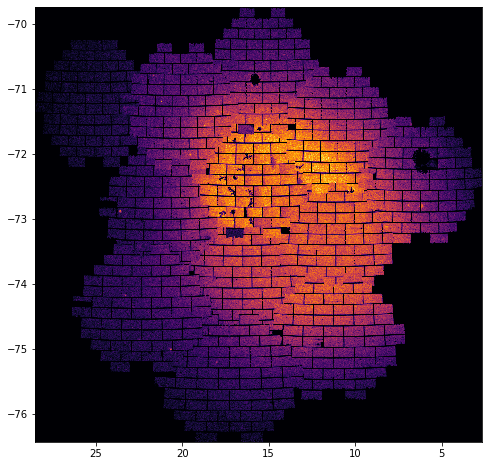

In [26]:
plt.figure(figsize=(8,8))
plt.hist2d(catalogue_all['RA'], catalogue_all['DEC'], bins=1000, cmap='inferno', vmin=1)
plt.gca().invert_xaxis()
plt.show()

In [4]:
coordinates = SkyCoord(catalogue_all['RA']*u.deg, catalogue_all['DEC']*u.deg)
SMC_centre = SkyCoord.from_name('SMC')
print(SMC_centre)

<SkyCoord (ICRS): (ra, dec) in deg
    (13.15833333, -72.80027778)>


In [125]:
pole = SMC_centre
fr = SkyOffsetFrame(origin=pole)
coordinates_ms = coordinates.transform_to(gc.MagellanicStreamNidever08)
coordinates_smc = coordinates.transform_to(fr)
print(coordinates_ms)

<SkyCoord (MagellanicStreamNidever08): (L, B) in deg
    [(-17.62589741, -13.54901818), (-17.62015917, -13.54742869),
     (-17.64121226, -13.53714069), ..., (-14.26095387,  -7.8327789 ),
     (-14.29347956,  -7.87084284), (-14.19477496,  -7.92651243)]>


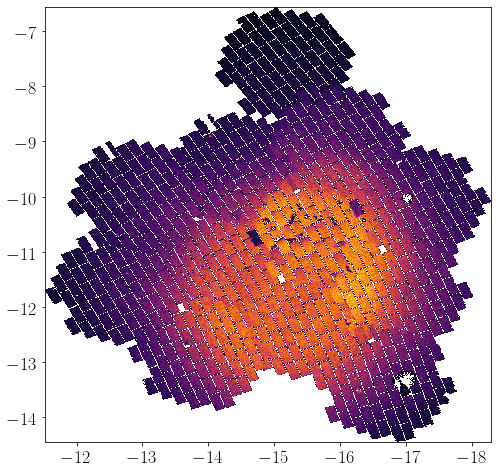

In [130]:
plt.figure(figsize=(8,8))
plt.hist2d(coordinates_ms.L.deg, coordinates_ms.B.deg, bins = 1000, vmin=1, cmap='inferno')
plt.gca().invert_xaxis()
plt.show()

In [35]:
crit = skm.projection.stdDistortion
proj = skm.Albers.optimize(coordinates.ra.deg, coordinates.dec.deg, crit)
print(proj)

optimizing parameters of Albers to minimize stdDistortion
best objective 0.000337 at Albers(14.635507568043632,-72.79695161847339,-74.89235295792743,-71.47075503815996)
Albers(14.635507568043632,-72.79695161847339,-74.89235295792743,-71.47075503815996)


/home/polmassana/anaconda3/lib/python3.7/site-packages/skymapper-0.4.2-py3.7.egg/skymapper/map.py:198: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


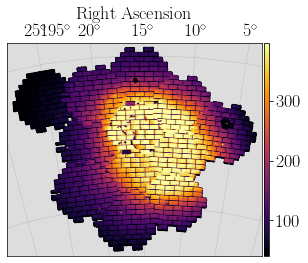

In [52]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})

map = skm.Map(proj)
sep = 5
map.grid(sep=sep)

nside = 2**12
mappable = map.density(coordinates.ra.deg, coordinates.dec.deg, nside=nside, cmap='inferno')
cb = map.colorbar(mappable)

map.ax.set_xlabel('Right Ascension')
map.ax.set_ylabel('Declination')
map.ax.set_xticks([5, 10, 15, 20, 25])

map.focus(coordinates.ra.deg, coordinates.dec.deg)

map.fig.savefig('/home/polmassana/Documents/PhD/SFH/SMC_test5_field/density_map.pdf')

# Helpy attempt

In [14]:
power = 12
pixlist = hp.ang2pix(2**power, coordinates.ra.deg, coordinates.dec.deg, lonlat=True)
pixels, counts = np.unique(pixlist, return_counts=True)
hpxmap = np.zeros(hp.nside2npix(2**power), dtype=np.int16)
for i, num in zip(pixels, counts):
    hpxmap[i] = num

In [15]:
area = 0.
bin_area = (hp.nside2resol(2**power, arcmin=True)/60.)**2
area = len(pixels)*bin_area
print(area)

30.98604109435495


In [60]:
centre_ra = (np.max(coordinates.ra.deg)+np.min(coordinates.ra.deg))/2.
centre_dec = (np.max(coordinates.dec.deg)+np.min(coordinates.dec.deg))/2.

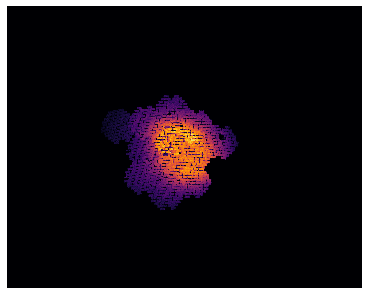

In [21]:
xsize = 1450
ysize = 1150
reso = hp.nside2resol(2**power, arcmin=True)
#reso = 2.
array_map = hp.gnomview(hpxmap, reso=reso, notext=True, title='', cmap='inferno', xsize=xsize, ysize=ysize, min = 1, rot=(SMC_centre.ra.deg, SMC_centre.dec.deg, 0), coord='C', return_projected_map=True, cbar=False)


In [218]:
hp.nside2resol(2**10, arcmin=True)

3.435486411817406

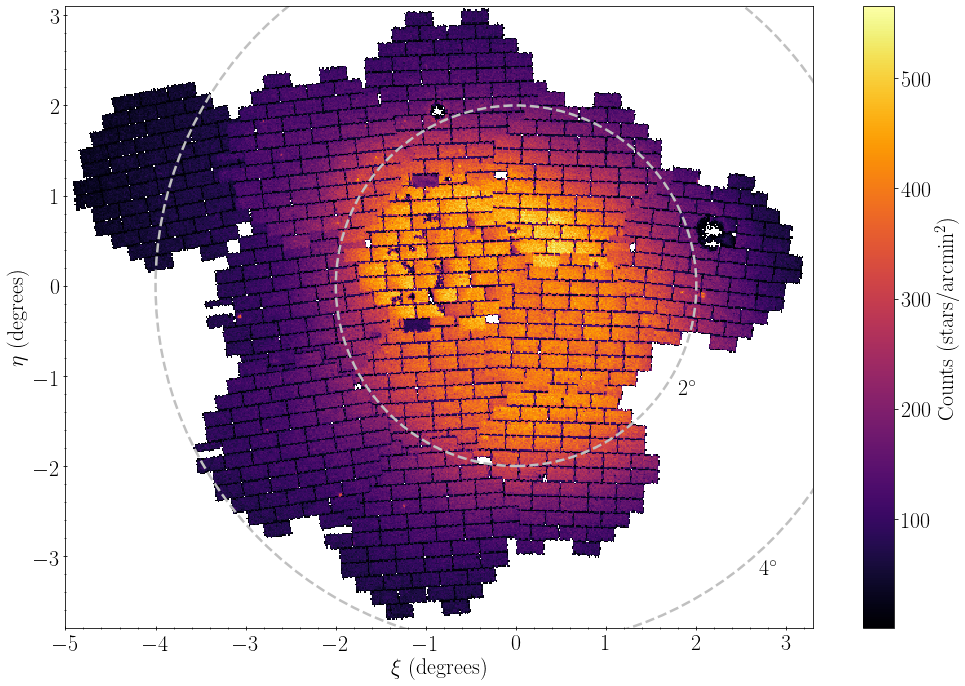

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':22})

fig = plt.figure(1,figsize=(15,10))
ax = fig.add_subplot(111)

scale = hp.nside2resol(2**power, arcmin=True)/60.
top = -(scale) * (ysize/2.)
bottom =  (scale) * (ysize/2.)
left = -(scale) * (xsize/2.)
right = (scale) * (xsize/2.)

arcmin2 = 1./hp.nside2resol(2**power, arcmin=True)**2

mappable = ax.imshow(array_map*arcmin2, origin='lower', cmap='inferno', extent=[left, right, top, bottom], vmin = 1)
#ax.grid(True, zorder=2)
cb = plt.colorbar(mappable, label = 'Counts (stars/arcmin$^{2}$)')

circle_2 = patches.Circle((0,0), radius=2, fill=False, ls='--', ec='silver', lw=2.5)
ax.add_patch(circle_2)
circle_4 = patches.Circle((0,0), radius=4, fill=False, ls='--', ec='silver', lw=2.5)
ax.add_patch(circle_4)

ax.annotate('2$^{\circ}$', (1.8,-1.2))
ax.annotate('4$^{\circ}$', (2.7,-3.2))

ax.set_xlabel(r'$\xi$ (degrees)')
ax.set_ylabel(r'$\eta$ (degrees)')
ax.set_xlim(-5,3.3)
ax.set_ylim(-3.8, 3.1)
ax.minorticks_on()
ax.tick_params(which='both', direction='inout')

fig.tight_layout()
fig.savefig('/home/polmassana/Documents/PhD/SFH/SMC_test5_field/density_map.png')

In [19]:
array_map.shape

(1150, 1450)

# Voronoi map

In [232]:
nside = 2**12

In [224]:
voronoi_data = fits.getdata(path_outputs+'voronoi_binning_results.fits.gz')

In [225]:
voronoi_data

FITS_rec([(14.09915014, -69.73588496, 4., 1.95092888e+08, 72.),
          (14.20113314, -69.73588496, 2., 1.95092890e+08, 72.),
          (14.25212465, -69.73588496, 4., 1.95092891e+08, 72.), ...,
          (18.34177215, -76.43404649, 1., 1.98516013e+08, 32.),
          (18.56962025, -76.43404649, 3., 1.98516016e+08, 32.),
          (18.79746835, -76.43404649, 1., 1.98516019e+08, 32.)],
         dtype=(numpy.record, [('RA', '>f8'), ('DEC', '>f8'), ('counts', '>f8'), ('idpix', '>f8'), ('bin_num', '>f8')]))

In [233]:
hp.ang2pix(nside, voronoi_data['RA'], voronoi_data['DEC'], lonlat=True)

array([195092888, 195092890, 195092891, ..., 198516013, 198516016,
       198516019])

In [234]:
hpx_voronoi_map = np.zeros(hp.nside2npix(nside), dtype=np.int8)
for i, num in enumerate(voronoi_data['idpix']):
    #print(i, num)
    hpx_voronoi_map[int(num)] = voronoi_data['bin_num'][i]

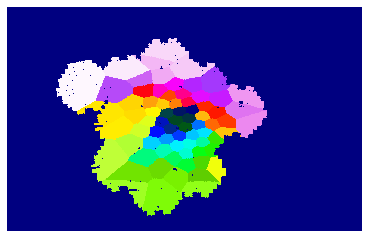

In [243]:
xsize = 950
ysize = 600
reso = hp.nside2resol(nside, arcmin=True)
#reso = 2.
array_map_voronoi = hp.gnomview(hpx_voronoi_map, reso=reso, notext=True, title='', cmap='gist_ncar', xsize=xsize, ysize=ysize, min = 1, rot=(SMC_centre.ra.deg, SMC_centre.dec.deg, 0), coord='C', return_projected_map=True, cbar=False)

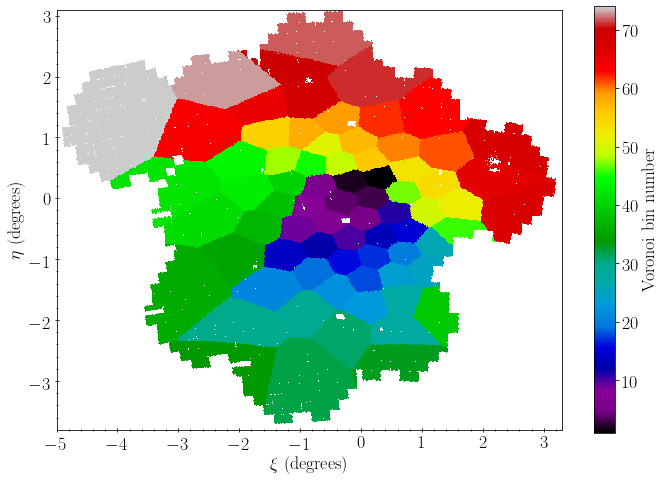

In [249]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})

fig = plt.figure(1,figsize=(10,7))
ax = fig.add_subplot(111)

scale = hp.nside2resol(nside, arcmin=True)/60.
top = -(scale) * (ysize/2.)
bottom =  (scale) * (ysize/2.)
left = -(scale) * (xsize/2.)
right = (scale) * (xsize/2.)

#arcmin2 = 1./hp.nside2resol(2**power, arcmin=True)

array_map_voronoi[array_map_voronoi==0.] = np.nan
mappable = ax.imshow(array_map_voronoi, origin='lower', cmap='nipy_spectral', extent=[left, right, top, bottom])
#ax.grid(True, zorder=2)
cb = plt.colorbar(mappable, label = 'Voronoi bin number')

#circle_2 = patches.Circle((0,0), radius=2, fill=False, ls='--', ec='silver', lw=2.5)
#ax.add_patch(circle_2)
#circle_4 = patches.Circle((0,0), radius=4, fill=False, ls='--', ec='silver', lw=2.5)
#ax.add_patch(circle_4)
#ax.annotate('2$^{\circ}$', (1.8,-1.2))
#ax.annotate('4$^{\circ}$', (2.7,-3.2))

ax.set_xlabel(r'$\xi$ (degrees)')
ax.set_ylabel(r'$\eta$ (degrees)')
ax.set_xlim(-5,3.3)
ax.set_ylim(-3.8, 3.1)
ax.minorticks_on()
ax.tick_params(which='both', direction='inout')

fig.tight_layout()
fig.savefig('/home/polmassana/Documents/PhD/SFH/SMC_test5_field/voronoi_map.pdf')